In [2]:
import numpy
print(numpy.__version__, numpy.__path__)

1.23.3 ['/home/jon/projects/machinehearing/handson/constrained-hmm/venv/lib/python3.10/site-packages/numpy']


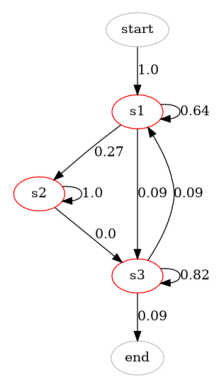

In [3]:
from pomegranate import HiddenMarkovModel, State, DiscreteDistribution
from matplotlib import pyplot as plt

def build_model():

    d1 = DiscreteDistribution({'A' : 0.50, 'B' : 0.50})
    d2 = DiscreteDistribution({'A' : 0.10, 'B' : 0.90})
    d3 = DiscreteDistribution({'A' : 0.90, 'B' : 0.10})

    s1 = State(d1, name="s1")
    s2 = State(d2, name="s2")
    s3 = State(d3, name="s3")

    model = HiddenMarkovModel(name='my model')
    model.add_states(s1, s2, s3)
    model.add_transition(model.start, s1, 1.0)
    model.add_transition(s1, s1, 0.7)
    model.add_transition(s1, s2, 0.3) # s1->s2
    model.add_transition(s2, s2, 0.8)
    
    model.add_transition(s2, s3, 0.0) # no transition from s2 to s3
    model.add_transition(s1, s3, 0.1) # indirect from s1 to s3
    model.add_transition(s3, s1, 0.1) # indirect from s3 to s1
    
    model.add_transition(s3, s3, 0.9)
    model.add_transition(s3, model.end, 0.1)
    model.start.name = 'start'
    model.end.name = 'end'
    model.bake()

    return model

model = build_model()
fig, ax = plt.subplots(1)
model.plot(ax=ax, precision=2)
fig.savefig('model.png')

In [27]:
print(", ".join(state.name for i, state in model.viterbi(list('ABBAAA'))[1]))

start, s1, s1, s1, s3, s3, s3, end


<AxesSubplot:xlabel='time'>

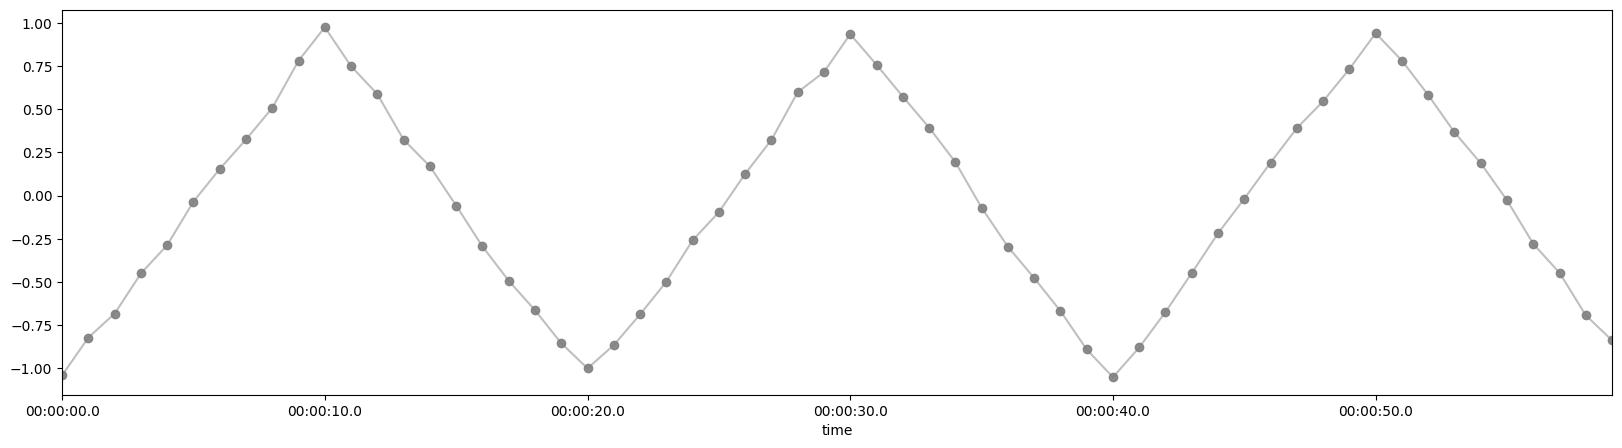

In [187]:
import pandas
import scipy.signal

def sinewave(freq, duration, samplerate):

    sin = numpy.sin(2*numpy.pi*(freq/samplerate)*t)
    return sin, t

def triangle(freq, duration, samplerate, phase=0.5):

    t = numpy.arange(samplerate*duration)
    triangle = scipy.signal.sawtooth(2*numpy.pi*freq*(t/samplerate), phase)
    return triangle, t
    
def make_series(shape='triangle', period='10sec', freq='1sec', duration='1min'):
    period = pandas.Timedelta(period)
    duration = pandas.Timedelta(duration)
    freq = pandas.Timedelta(freq)
    
    if shape == 'sine':
        w = sinewave(1/period.total_seconds(), duration.total_seconds(), freq.total_seconds())
    elif shape == 'triangle':
        w = triangle(1/period.total_seconds(), duration.total_seconds(), freq.total_seconds())
    else:
        raise ValueError(f"Unknown shape '{shape}'")
    y, t = w
    y = y + (-.1 * numpy.random.random(size=len(y)) )
    #y = 0
    t = pandas.to_timedelta(t, unit='s')
    s = pandas.Series(y, index=t)
    s.index.name = 'time'
    return s


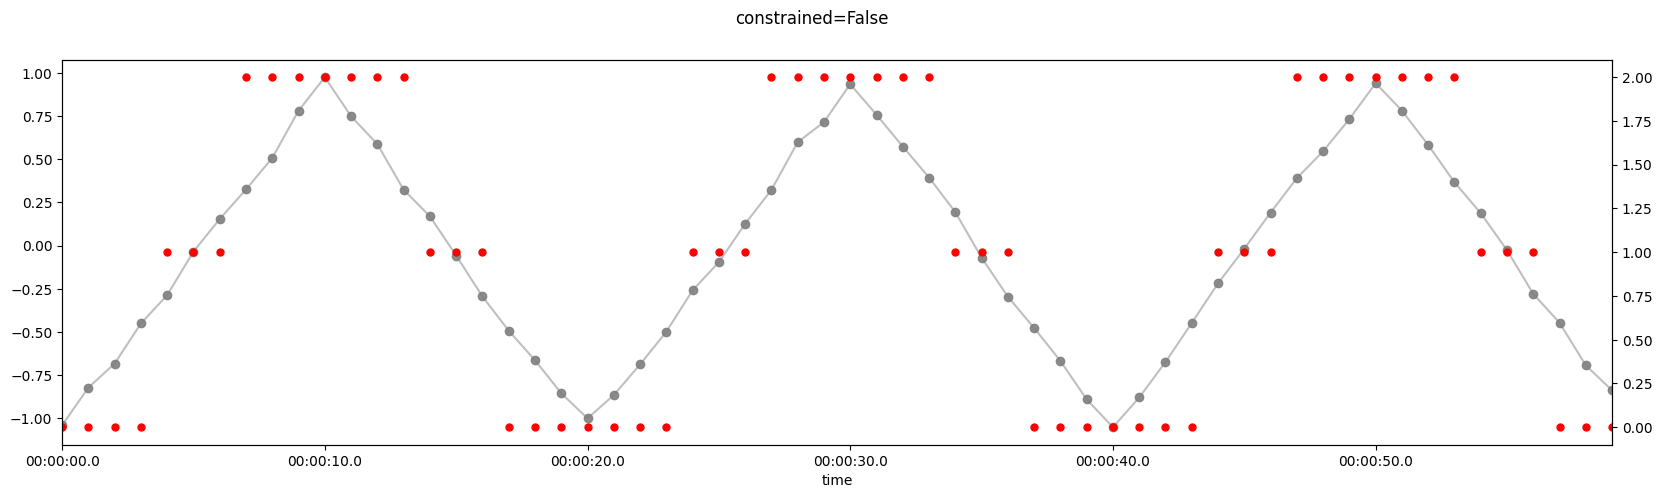

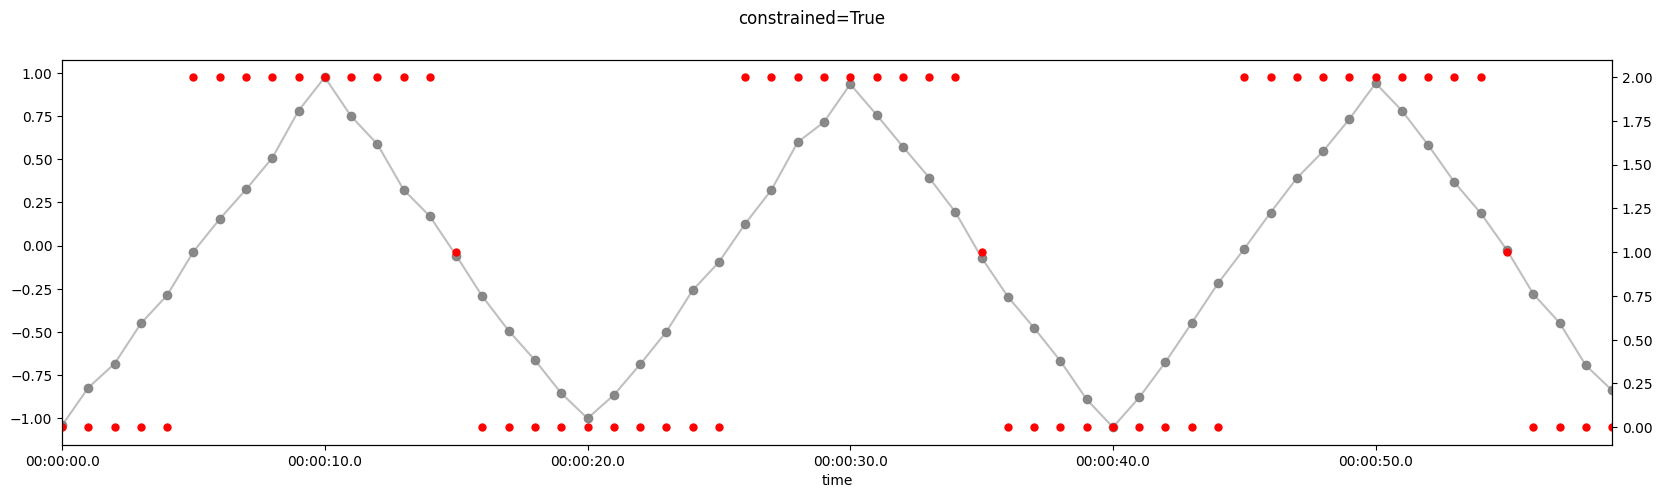

In [191]:
from hmmlearn.hmm import GMMHMM

class ConstrainedGMMHMM(GMMHMM):
    
    def _do_mstep(self, stats):
        
        # do the standard learning
        super()._do_mstep(stats)
        
        # find which states are where
        # we name them based on their typical value
        m = numpy.squeeze(self.means_)
        s = numpy.argsort(m)
        s1, s2, s3 = s
        
        # constrain the transition matrix
        # disallow s1->s2 and/or s2->s3 is not allowed
        
        self.transmat_[s1,s2] = 0.0
        self.transmat_[s2,s3] = 0.0

        # make sure the probabiliies sum to 1.0
        # XXX: note needed, fails when enabled??
        #from hmmlearn.utils import normalize
        #normalize(self.transmat_)


def learn_example(X, constrain=True):
    if constrain:
        Model = ConstrainedGMMHMM
    else:
        Model = GMMHMM

    model = Model(n_components=3, n_mix=1, covariance_type='diag')
    model.fit(X)

    return model

# FIXME: use multiple sequences. Make conversion utility from list of series
def map_data(s):
    return s.values.reshape(-1, 1)



def test_model(X, constrain):
    X = samples[0]
    model = learn_example(map_data(X), constrain=constrain)

    # sort states based on their value
    mapping = numpy.argsort(numpy.squeeze(model.means_))
    inv_mapping = numpy.argsort(mapping)

    states = inv_mapping[numpy.argmax(model.score_samples(map_data(X))[1], axis=1)]
    states = pandas.Series(states, index=X.index)

    fig, ax = plt.subplots(1, figsize=(20, 5))
    samples[0].plot(ax=ax, marker='o', ls='none', color='grey', alpha=0.9)
    samples[0].plot(ax=ax, ls='-', alpha=0.5, color='grey')

    ax2 = ax.twinx()
    states.plot(ax=ax2,ls='none', marker='o', ms=5, color='red')
    fig.suptitle(f'constrained={constrain}')

X = make_series(period='20sec'),
test_model(X, constrain=False)
test_model(X, constrain=True)

    
#print(states)

In [162]:

import pomegranate.callbacks
class ConstraintCallback(pomegranate.callbacks.Callback):
    """
    Callback class for 
    """
    def __init__(self, constrain_func):
        self._constrain_func = constrain_func
    
    def on_epoch_end(self, logs):
        
        assert self.model, "Model is not known"
        self._constrain_func(self.model)

        
def learn_from_samples_with_constraints(distribution,
                n_components=5,
                X=None,
                callbacks=[],
                constraints=None,
                *args, **kwargs):
    """
    Convenience wrapper around pomegranate.HiddenMarkovModel.from_samples
    
    Sets 
    """
    
    assert constraints, "Must specify a constraining function"
    
    callbacks.append(
        ConstraintCallback(constraints),
    )
    

    model = HiddenMarkovModel.from_samples(distribution,
                n_components=n_components,
                X=X,
                callbacks=callbacks,
                *args, **kwargs)
    
    return model


            
"""
transitions will be learned from data

    s1->s2 and/or s2->s3 is not allowed
but s3->s2->s1 is
"""    
def constrain_tristate_up(model):
    #print('cons', model)
        
    #self.in_transitions
    #self.in_edge_count
    #self.in_transition_pseudocounts
    #self.in_transition_log_probabilities

    #self.out_transitions
    #self.out_edge_count
    #self.out_transition_pseudocounts
    #self.out_transition_log_probabilities
    t = getattr(model, 'expected_transitions', None)
    #print(t)
        
    #print(model.__dict__())
    #print(dir(model))
    #print(model.n_edges)
    
    # XXX: no way to access the transitions, neither read nor modify
    

def learn_example(X):
    model = learn_from_samples_with_constraints(distribution=pomegranate.NormalDistribution,
                                                X=samples,
                                                n_components=3,
                                                constraints=constrain_tristate_up)
    return model

model = learn_example(samples)
get_parameters(model)

,mean,std
name,,
s0,-0.760322,0.248854
s1,0.855834,0.074760
s2,0.233826,0.279956


In [76]:

def get_parameters(model):
    parameters = dict(
        name = [],
        mean = [],
        std = [],
    )
    
    for s in model.states:
        if not s.name.startswith('s'):
            # skip start/end state
            continue

        mean, std = s.distribution.parameters
        parameters['mean'].append(mean)
        parameters['std'].append(std)
        parameters['name'].append(s.name)
            
    df = pandas.DataFrame(parameters).set_index('name')
    return df

get_parameters(model)

,mean,std
name,,
s0,-0.747907,0.225812
s1,0.105317,0.267478
s2,0.827549,0.153620
